<a href="https://colab.research.google.com/github/anisshakil786/Weather_Image_Recognition/blob/main/Machine_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
# import warnings
# warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
import shutil
from math import ceil

# Define source and target directories
src_dir = '/content/drive/MyDrive/Machine_Learning/dataset'
target_dir1 = '/content/drive/MyDrive/Machine_Learning/dataset2_1'
target_dir2 = '/content/drive/MyDrive/Machine_Learning/dataset2_2'

# Create a list of subfolders (weather conditions)
subfolders = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']

# For each subfolder, split the files into 20% and 80%
for subfolder in subfolders:
    # Get the list of files in the subfolder
    files = os.listdir(os.path.join(src_dir, subfolder))

    # Calculate the split index
    split_idx = ceil(len(files) * 0.20)

    # Split the files into two lists
    files1 = files[:split_idx]
    files2 = files[split_idx:]

    # Create the corresponding subfolder in target_dir1 and target_dir2
    os.makedirs(os.path.join(target_dir1, subfolder), exist_ok=True)
    os.makedirs(os.path.join(target_dir2, subfolder), exist_ok=True)

    # Copy the files to the new directories
    for file in files1:
        shutil.copy(os.path.join(src_dir, subfolder, file), os.path.join(target_dir1, subfolder, file))
    for file in files2:
        shutil.copy(os.path.join(src_dir, subfolder, file), os.path.join(target_dir2, subfolder, file))


In [ ]:
# Generate data paths with labels
data_dir = '/content/drive/MyDrive/Machine_Learning/dataset2_1'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

filepaths labels
0     /content/drive/MyDrive/Machine_Learning/datase...    dew
1     /content/drive/MyDrive/Machine_Learning/datase...    dew
2     /content/drive/MyDrive/Machine_Learning/datase...    dew
3     /content/drive/MyDrive/Machine_Learning/datase...    dew
4     /content/drive/MyDrive/Machine_Learning/datase...    dew
...                                                 ...    ...
1375  /content/drive/MyDrive/Machine_Learning/datase...   snow
1376  /content/drive/MyDrive/Machine_Learning/datase...   snow
1377  /content/drive/MyDrive/Machine_Learning/datase...   snow
1378  /content/drive/MyDrive/Machine_Learning/datase...   snow
1379  /content/drive/MyDrive/Machine_Learning/datase...   snow

[1380 rows x 2 columns]

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df, train_size=0.7, stratify=df['labels'], shuffle=True, random_state=123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df, train_size=0.33, stratify=dummy_df['labels'], shuffle=True, random_state=123)

In [ ]:
# crobed image size
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
#test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_batch_size = 32
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 965 validated image filenames belonging to 11 classes.
Found 136 validated image filenames belonging to 11 classes.
Found 279 validated image filenames belonging to 11 classes.


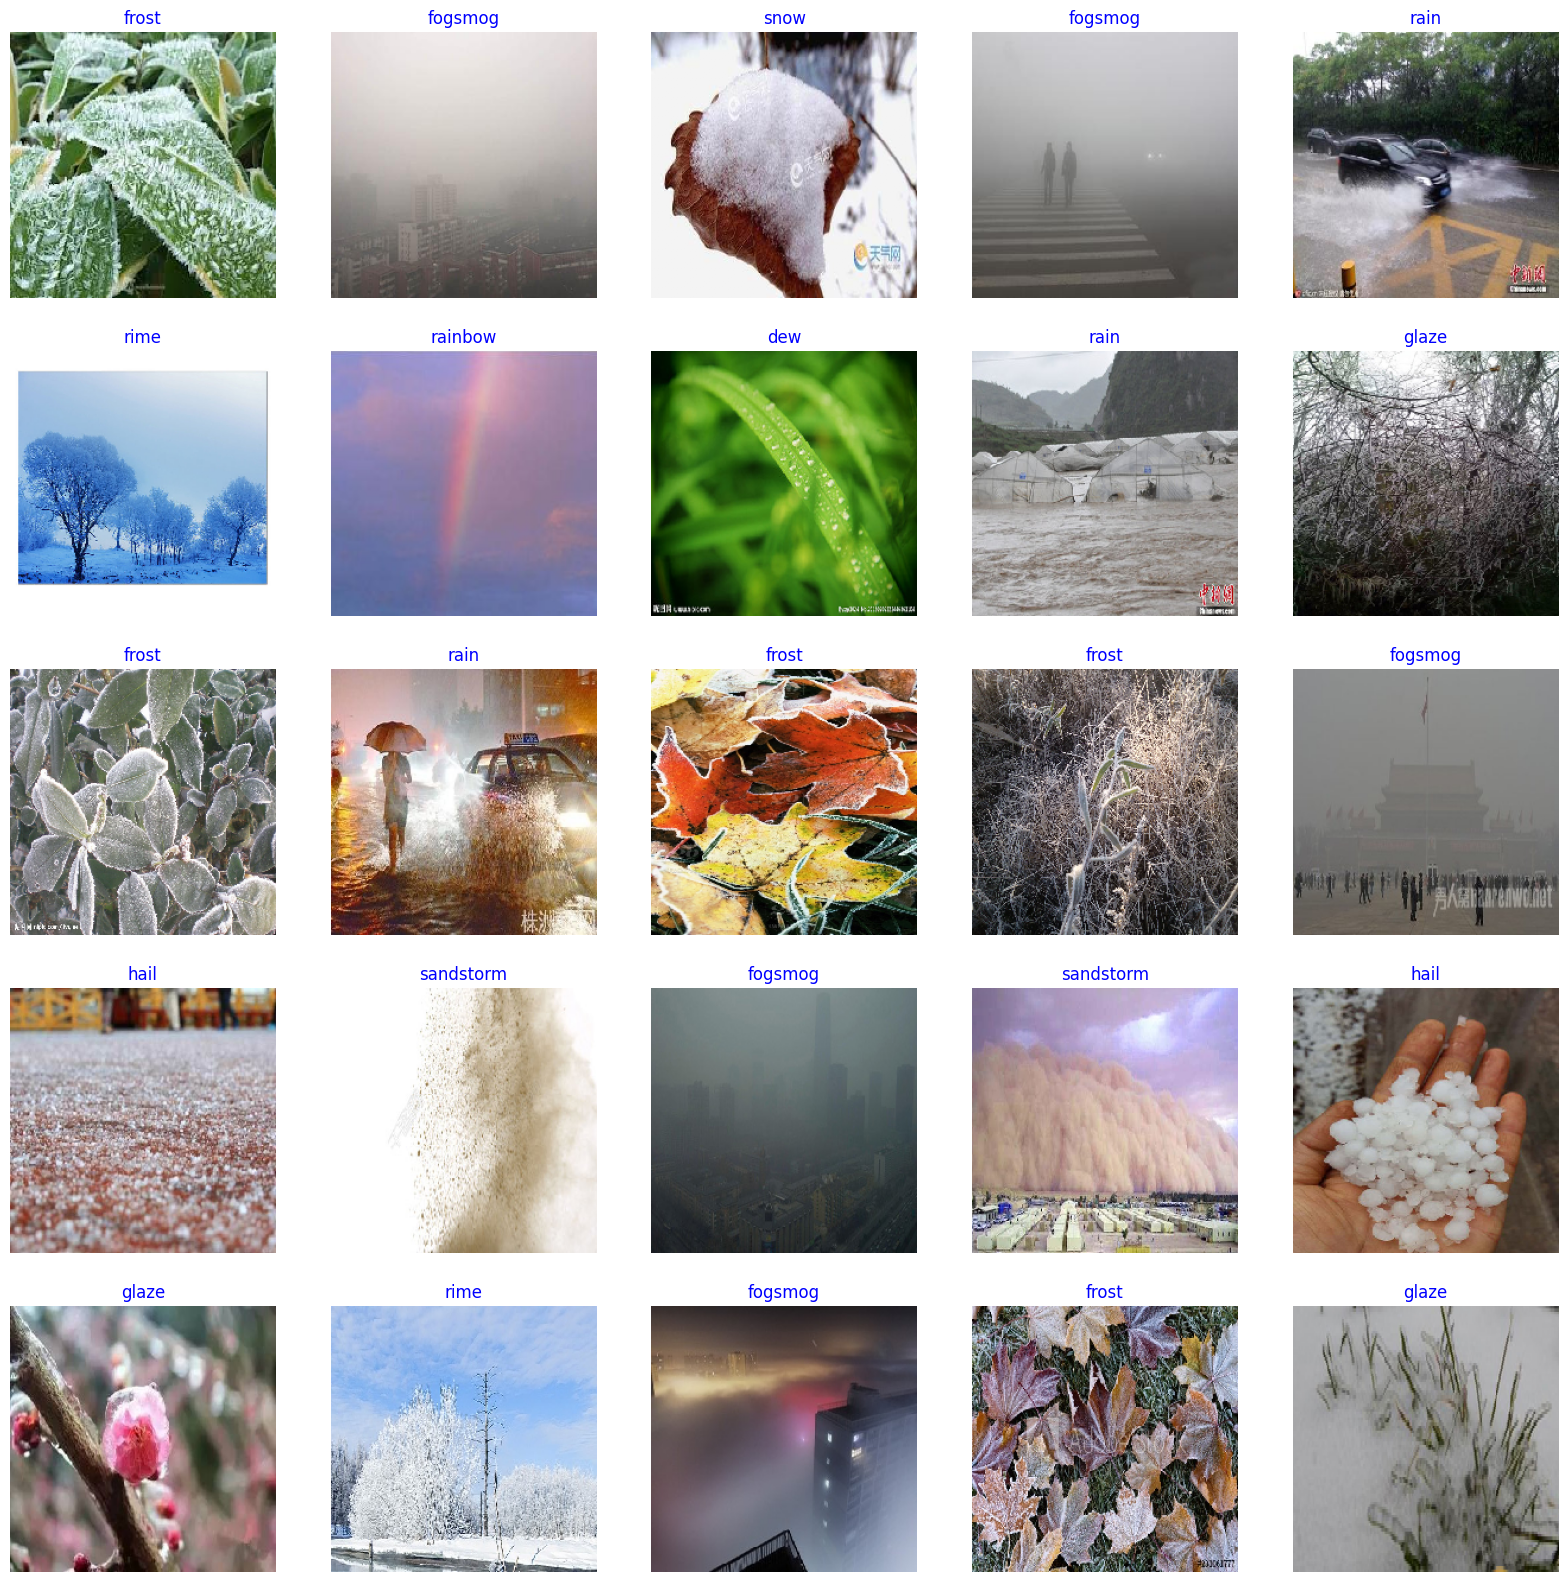

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 11)                2827      
                                                                 
Total params: 11185978 (42.67 MB)
Trainable params: 1109

In [ ]:
epochs = 20   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/20
31/31 [==============================] - 630s 19s/step - loss: 9.4237 - accuracy: 0.4850 - val_loss: 9.1819 - val_accuracy: 0.6176
Epoch 2/20
31/31 [==============================] - 548s 18s/step - loss: 7.7181 - accuracy: 0.8135 - val_loss: 7.6080 - val_accuracy: 0.8088
Epoch 3/20
31/31 [==============================] - 548s 18s/step - loss: 7.0161 - accuracy: 0.8881 - val_loss: 7.0553 - val_accuracy: 0.8382
Epoch 4/20
31/31 [==============================] - 540s 17s/step - loss: 6.4756 - accuracy: 0.9399 - val_loss: 6.5628 - val_accuracy: 0.8456
Epoch 5/20
31/31 [==============================] - 538s 17s/step - loss: 6.0387 - accuracy: 0.9596 - val_loss: 6.1393 - val_accuracy: 0.8824
Epoch 6/20
31/31 [==============================] - 543s 18s/step - loss: 5.6487 - accuracy: 0.9617 - val_loss: 5.8012 - val_accuracy: 0.8750
Epoch 7/20
31/31 [==============================] - 536s 17s/step - loss: 5.3262 - accuracy: 0.9782 - val_loss: 5.4750 - val_accuracy: 0.8750
Epoch 

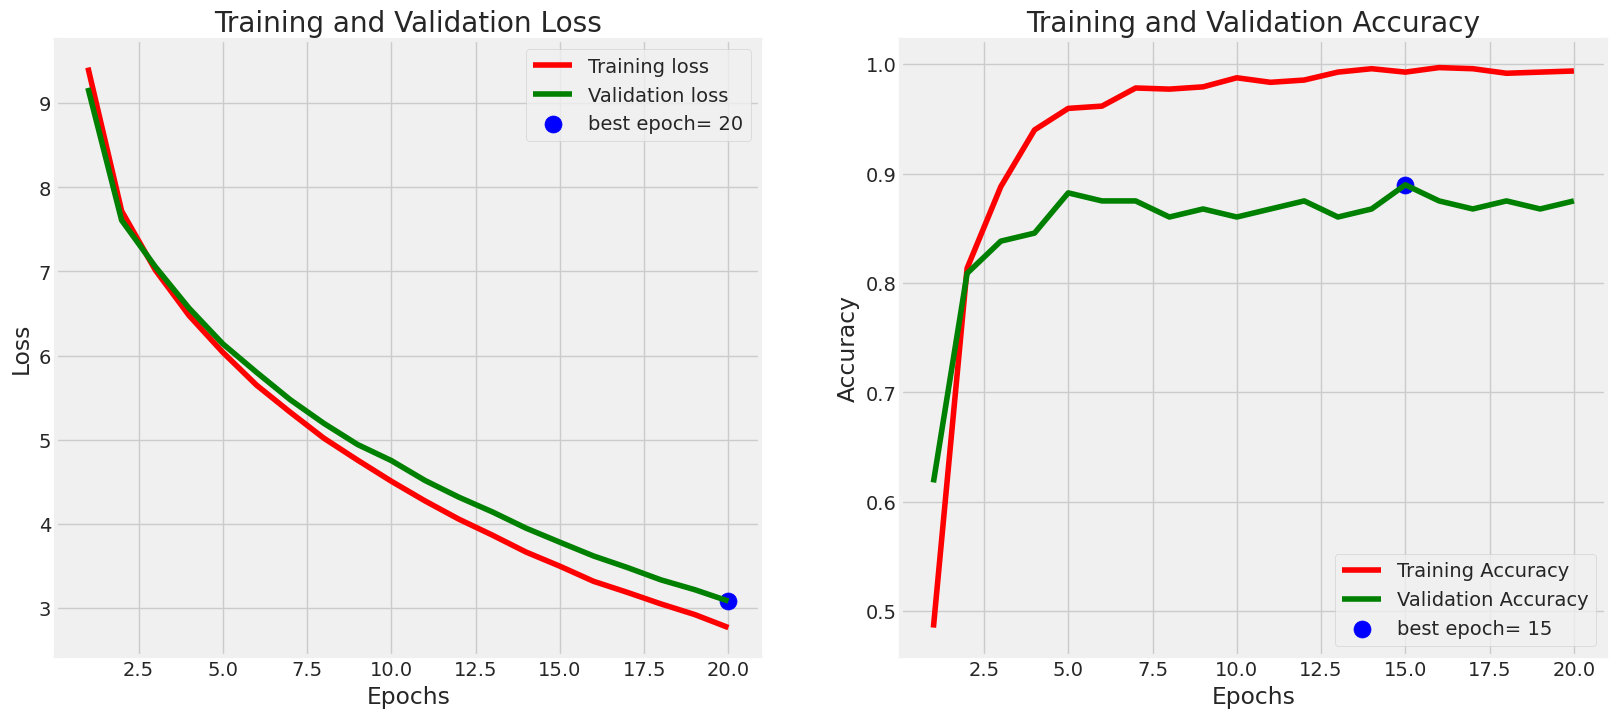

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/9 [===============>..............] - ETA: 11s - loss: 3.0803 - accuracy: 0.8750

9/9 [==============================] - 34s 4s/step - loss: 3.0342 - accuracy: 0.8817
Train Loss:  2.6464052200317383
Train Accuracy:  1.0
--------------------
Validation Loss:  3.0803420543670654
Validation Accuracy:  0.875
--------------------
Test Loss:  3.0341849327087402
Test Accuracy:  0.8817204236984253


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

9/9 [==============================] - 50s 5s/step


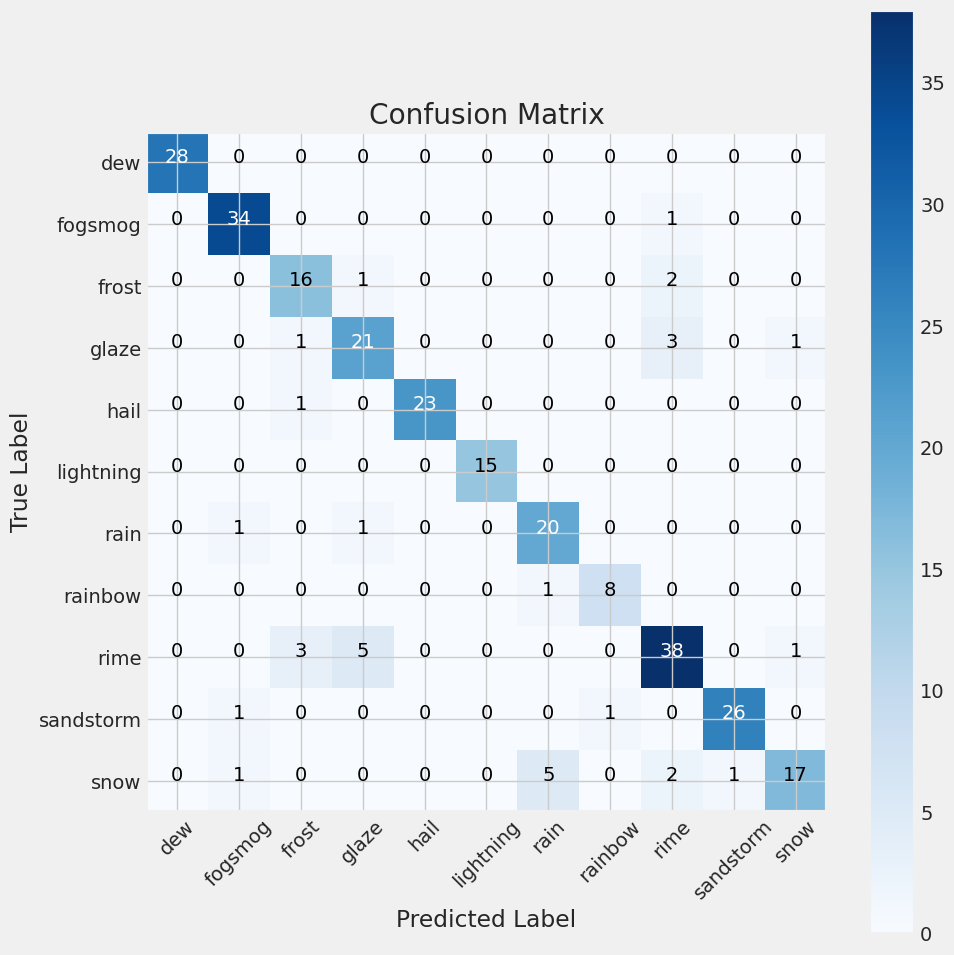

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         dew       1.00      1.00      1.00        28
     fogsmog       0.92      0.97      0.94        35
       frost       0.76      0.84      0.80        19
       glaze       0.75      0.81      0.78        26
        hail       1.00      0.96      0.98        24
   lightning       1.00      1.00      1.00        15
        rain       0.77      0.91      0.83        22
     rainbow       0.89      0.89      0.89         9
        rime       0.83      0.81      0.82        47
   sandstorm       0.96      0.93      0.95        28
        snow       0.89      0.65      0.76        26

    accuracy                           0.88       279
   macro avg       0.89      0.89      0.89       279
weighted avg       0.89      0.88      0.88       279



In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Machine_Learning/ML_Model.h5')

model.save('/content/drive/MyDrive/Machine_Learning/ML_Model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Machine_Learning/ML_Model.keras', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/drive/MyDrive/Machine_Learning/dataset/glaze/6191.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 209ms/step
glaze
